In [182]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures

In [183]:
# read in all the words
words = open('Datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [184]:
len(words)

32033

In [5]:
# build the vocabulary of the characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [70]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '------>', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [189]:
# build the dataset

def build_dataset(words):
    
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [16]:
C = torch.rand((27, 2))

In [24]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [26]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [46]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.2289,  3.1799,  2.7302,  ...,  4.5640,  1.6523,  3.4928],
        [-0.6759,  2.4921,  2.5278,  ...,  4.3617,  0.9659,  3.2710],
        [-0.8939,  2.3772,  2.6060,  ...,  3.4278,  0.3844,  3.3941],
        ...,
        [ 1.1980,  0.7816,  1.2551,  ...,  3.1584,  1.9429,  0.5966],
        [ 1.0342,  4.2258,  1.6768,  ...,  1.5684,  2.2369,  3.2189],
        [ 1.4383,  1.4331,  2.1020,  ...,  2.5012,  0.6833,  2.1827]])

In [47]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [49]:
logits = h@W2 + b2

In [50]:
logits.shape

torch.Size([32, 27])

In [51]:
counts = logits.exp()

In [52]:
prob = counts / counts.sum(1, keepdims=True)

In [53]:
prob.shape

torch.Size([32, 27])

In [55]:
loss = -prob[torch.arange(32), Y].log().mean()
print(loss)

tensor(inf)


# ------- now made respectable --------

In [190]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [237]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [238]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [239]:
for p in parameters:
    p.requires_grad = True

In [240]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []


In [254]:
for i in range(200000):
    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    #forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @W1 + b1) # (32, 100)
    logits = h @W2 + b2 # (32, 37)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    # update
    for p in parameters:
        p.data  += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item()) # Print loss for the minibatch


2.0949385166168213


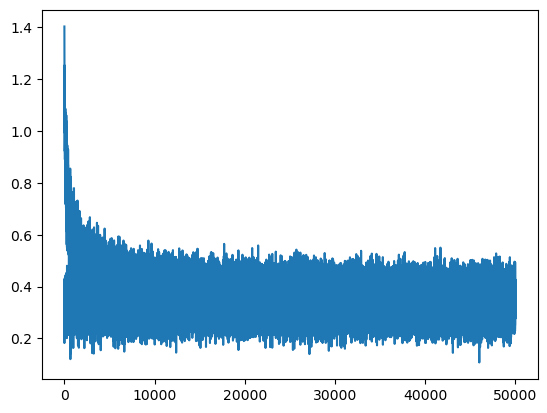

In [251]:
plt.plot(stepi, lossi)

In [255]:
# Print Loss for the entire dataset
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h@W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1381, grad_fn=<NllLossBackward0>)

In [256]:
# Print Loss for the entire dataset
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h@W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0864, grad_fn=<NllLossBackward0>)

In [ ]:
plt.plot(lri, lossi)

# training split, dev/  validation splikt, test split
# 80%, 10%, 10%
# USed to optimise parameters, used for development over all the hyperparameters, Validate the performance of the model at the end
# You're only allowed to test on the test split a few times, else you over fit to it

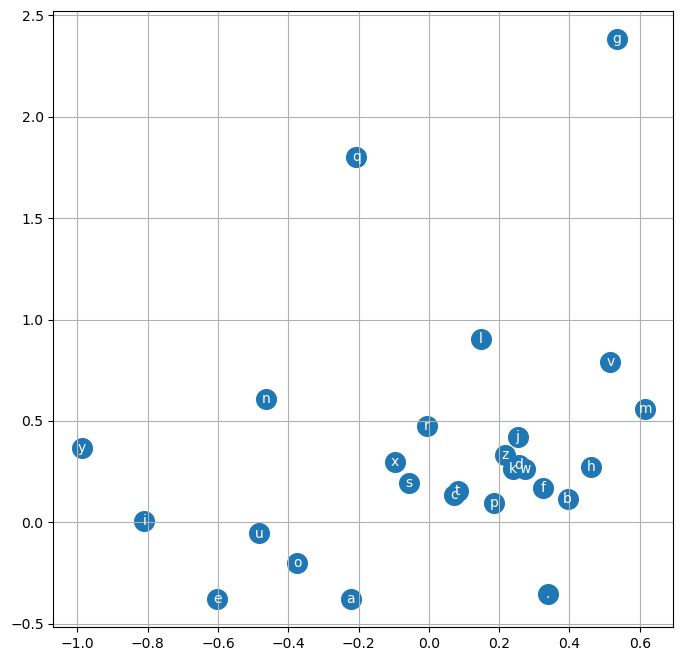

In [234]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid('minor')

In [260]:
# sample from the model
g=torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrilli.
taty.
skany.
kens.
hut.
faresynci.
geni.
ner.
kiah.
maiiy.
kaleigh.
ham.
prin.
quinn.
sulie.
alianni.
wajtaz.
dearynn.
